In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [8]:
import pandas as pd

# Define file paths
training_file_path = r"C:\Users\sombe\Downloads\TRAINING_DATA.txt"
test_file_path = r"C:\Users\sombe\Downloads\REAL_DATA.txt"

# Read and process the TRAINING dataset
with open(training_file_path, "r", encoding="utf-8") as file:
    train_lines = file.readlines()

train_data = []
for line in train_lines:
    try:
        label = int(line[0])  # First character is the label (0 or 1)
        text = line[2:].strip()  # Extract text after the label
        train_data.append([text, label])
    except ValueError:
        print(f"Skipping invalid training line: {line}")

# Convert to DataFrame
training_data = pd.DataFrame(train_data, columns=["text", "label"])

# Read and process the REAL dataset (test data)
with open(test_file_path, "r", encoding="utf-8") as file:
    test_lines = file.readlines()  # ← FIXED: Added missing parentheses ()

real_data = []
for line in test_lines:
    try:
        label = int(line[0])  # First character is the label (0 or 1)
        text = line[2:].strip()  # Extract text after the label
        real_data.append([text, label])
    except ValueError:
        print(f"Skipping invalid test line: {line}")

# Convert to DataFrame
real_data = pd.DataFrame(real_data, columns=["text", "label"])

# Print dataset shapes for verification
print("Training Set Size:", training_data.shape)
print("Test Set Size:", real_data.shape)

# Save cleaned datasets (optional)
training_data.to_csv("cleaned_training_data.csv", index=False)
real_data.to_csv("cleaned_real_data.csv", index=False)

# Display first few rows
print("\nTraining Data Sample:")
print(training_data.head())

print("\nTest Data Sample:")
print(real_data.head())


Training Set Size: (17877, 2)
Test Set Size: (2201, 2)

Training Data Sample:
                                                text  label
0  Cuando conocí a Janice en 2013 , una familia n...      1
1  Hwang habló en Sur de este año por Southwest M...      0
2  Usted podría pensar Katy Perry y Robert Pattin...      1
3  Cualquiera que haya volado los cielos del crea...      1
4  Bueno , este cantante tendrá un LARGO tiempo p...      1

Test Data Sample:
                                                text  label
0  Yo no creo que a nadie le haya encantado un pe...      2
1  No va a resolver sus problemas de crédito o me...      2
2                                Te encantará este !      2
3  Yo estaba a volar a un aeropuerto varias horas...      2
4  ( Maid En Manhattan , The Wedding Planner , Je...      2


## Data Preprocessing

In [11]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


In [13]:
import re

def add_spaces_around_special_chars(text):
    """
    Adds spaces around special characters to ensure proper tokenization.
    """
    text = re.sub(r'([.,!?;()=<>-])', r' \1 ', text)  # Add spaces around punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [15]:
# Apply to both datasets
training_data['text'] = training_data['text'].astype(str).apply(add_spaces_around_special_chars)
real_data['text'] = real_data['text'].astype(str).apply(add_spaces_around_special_chars)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(real_data.head())


Training Data (First 5 Rows):
                                                text  label
0  Cuando conocí a Janice en 2013 , una familia n...      1
1  Hwang habló en Sur de este año por Southwest M...      0
2  Usted podría pensar Katy Perry y Robert Pattin...      1
3  Cualquiera que haya volado los cielos del crea...      1
4  Bueno , este cantante tendrá un LARGO tiempo p...      1

Test Data (First 5 Rows):
                                                text  label
0  Yo no creo que a nadie le haya encantado un pe...      2
1  No va a resolver sus problemas de crédito o me...      2
2                                Te encantará este !      2
3  Yo estaba a volar a un aeropuerto varias horas...      2
4  ( Maid En Manhattan , The Wedding Planner , Je...      2


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [18]:
import re

def clean_text(text):
    """Performs multiple text preprocessing steps in a single function."""
    if not isinstance(text, str):
        return ""

    # Step 1: Remove special characters (except letters, numbers, and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s¿?,;:¡!.ÑÁÉÍÓÚñáéíóúü]', '', text)

    # Step 2: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 3: Remove all single characters
    text = re.sub(r'\b\w\b', '', text)

    # Step 4: Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 7: Convert to lowercase
    text = text.lower()

    return text

# Ensure text column is a string before applying the function
training_data['text'] = training_data['text'].astype(str).apply(clean_text)
real_data['text'] = real_data['text'].astype(str).apply(clean_text)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(real_data.head())


Training Data (First 5 Rows):
                                                text  label
0  cuando conocí janice en , una familia necesita...      1
1  hwang habló en sur de este año por southwest m...      0
2  usted podría pensar katy perry robert pattinso...      1
3  cualquiera que haya volado los cielos del crea...      1
4  bueno , este cantante tendrá un largo tiempo p...      1

Test Data (First 5 Rows):
                                                text  label
0  yo no creo que nadie le haya encantado un pene...      2
1  no va resolver sus problemas de crédito mejora...      2
2                                te encantará este !      2
3  yo estaba volar un aeropuerto varias horas de ...      2
4  maid en manhattan , the wedding planner , jers...      2


In [20]:
import numpy as np

# If all values in 'label' are 2, replace them with NaN (empty for classification)
if real_data['label'].nunique() == 1 and 2 in real_data['label'].unique():
    real_data['label'] = np.nan  # Empty the column for classification

# Verify the changes
print("Updated unique values in label column:", real_data['label'].unique())



Updated unique values in label column: [nan]


## Now let's work on removing stopwords
Remove the stopwords.

In [23]:
# Your code
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def remove_stopwords(text):
    words = text.split()  # Tokenize text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)  # Join back into a single string

# Apply stopword removal to both datasets
training_data['text'] = training_data['text'].apply(remove_stopwords)
real_data['text'] = real_data['text'].apply(remove_stopwords)


In [27]:
# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(real_data.head())

Training Data (First 5 Rows):
                                                text  label
0  conocí janice , familia necesitaba puntos , pr...      1
1  hwang habló sur año southwest music and media ...      0
2  usted podría pensar katy perry robert pattinso...      1
3  cualquiera volado cielos creador escuchado act...      1
4  bueno , cantante largo tiempo sentir aún remor...      1

Test Data (First 5 Rows):
                                                text  label
0                creo nadie encantado pene flácido .    NaN
1  va resolver problemas crédito mejorar relación...    NaN
2                                        encantará !    NaN
3  volar aeropuerto varias horas distancia , alqu...    NaN
4  maid manhattan , the wedding planner , jersey ...    NaN


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [30]:
# Your code

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download resources if not already installed
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """ Map POS tag to first character for lemmatizer """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if tag not found

def lemmatize_text(text):
    """ Tokenize text and apply lemmatization """
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)  # Tokenize sentence into words
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemmatized_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
nltk.download('all')  # All to resolve the error of nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\sombe\AppData\Roaming\nltk_data...
[

True

In [34]:
# Apply lemmatization to both datasets
training_data['text'] = training_data['text'].astype(str).apply(lemmatize_text)
real_data['text'] = real_data['text'].astype(str).apply(lemmatize_text)

# Confirm changes
print("Training Data (First 5 Rows):")
print(training_data.head())

print("\nTest Data (First 5 Rows):")
print(real_data.head())



Training Data (First 5 Rows):
                                                text  label
0  conocí janice , familia necesitaba puntos , pr...      1
1  hwang habló sur año southwest music and medium...      0
2  usted podría pensar katy perry robert pattinso...      1
3  cualquiera volado cielos creador escuchado act...      1
4  bueno , cantante largo tiempo sentir aún remor...      1

Test Data (First 5 Rows):
                                                text  label
0                creo nadie encantado pene flácido .    NaN
1  va resolver problemas crédito mejorar relación...    NaN
2                                        encantará !    NaN
3  volar aeropuerto varias horas distancia , alqu...    NaN
4  maid manhattan , the wedding planner , jersey ...    NaN


In [35]:
print(training_data[['text']].head(10))
print(real_data[['text']].head(10))

                                                text
0  conocí janice , familia necesitaba puntos , pr...
1  hwang habló sur año southwest music and medium...
2  usted podría pensar katy perry robert pattinso...
3  cualquiera volado cielos creador escuchado act...
4  bueno , cantante largo tiempo sentir aún remor...
5  octubre , registra , hergé recibe carta anónim...
6  creo debamos seguir viéndonos bastante efectiv...
7           joe teresa giudice peligro perder casa ?
8  día tarde , historias surgieron servicio lugar...
9  viajó vega , días después cumplir , entrar eve...
                                                text
0                creo nadie encantado pene flácido .
1  va resolver problemas crédito mejorar relación...
2                                        encantará !
3  volar aeropuerto varias horas distancia , alqu...
4  maid manhattan , the wedding planner , jersey ...
5  padre llegó primera ola fuerzas aliadas día , ...
6                   podemos acuerdo envases mi

In [51]:
from sklearn.model_selection import train_test_split

# Split 80% training, 20% test
train_data, test_data = train_test_split(training_data, test_size=0.2, random_state=42, stratify=training_data['label'])

# Print dataset sizes to verify
print("Training Set Size:", train_data.shape)
print("Test Set Size:", test_data.shape)


Training Set Size: (14301, 2)
Test Set Size: (3576, 2)


In [43]:
print("Sample messages where label == 0:")
print(training_data[training_data['label'] == 0].sample(5))  # 5 random messages

print("\nSample messages where label == 1:")
print(training_data[training_data['label'] == 1].sample(5))  # 5 random messages


Sample messages where label == 0:
                                                    text  label
12481  pesar idiosincrasias , habilidad especial pron...      0
3819   complicado difícil expresar sentimientos encon...      0
1427   aunque hergé votó manera rutinaria listas famo...      0
14434  resultados rara vez terminado atraer ofertas p...      0
6362   jfj lidera serie financiación empresa enorme f...      0

Sample messages where label == 1:
                                                    text  label
10484  niño extranjero hace tiempo dijo vio obligado ...      1
246                             notas post it pulgadas .      1
12805  si construimos infraestructura thefamily paíse...      1
3327   partir entonces erin dominó mundo industria ed...      1
13481  existe presunción persona cierta clase sumidas...      1


In [ ]:
# Your code
'''
# Separate human and ai messages
ai_messages = training_data[training_data['label'] == 0]['text']
human_messages = training_data[training_data['label'] == 1]['text']


In [ ]:
'''
print("Sample HUman Messages:\n", human_messages.head())
print("Sample AI Messages:\n", ai_messages.head())

## TD-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF without stopword removal
vectorizer = TfidfVectorizer()  # No need for stop_words parameter

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(train_data['text'])

# Transform the test data using the same vectorizer (do not fit again)
X_test_tfidf = vectorizer.transform(test_data['text'])


In [63]:
print("Shape of Training Data (TF-IDF):", X_train_tfidf.shape)
print("Shape of Test Data (TF-IDF):", X_test_tfidf.shape)


Shape of Training Data (TF-IDF): (14301, 22449)
Shape of Test Data (TF-IDF): (3576, 22449)


## And the Train a Classifier?

In [67]:
# Your code
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
'''

# Define features (TF-IDF matrix) and labels (Spam=1, Ham=0)
X = X_train_tfidf  # Already vectorized training data
y = training_data['label']  # AI = 1, Human = 0

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)


Logistic Regression Accuracy: 0.3828
Multinomial Naive Bayes Accuracy: 0.3339


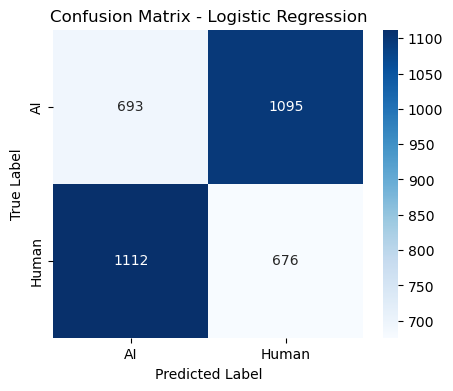

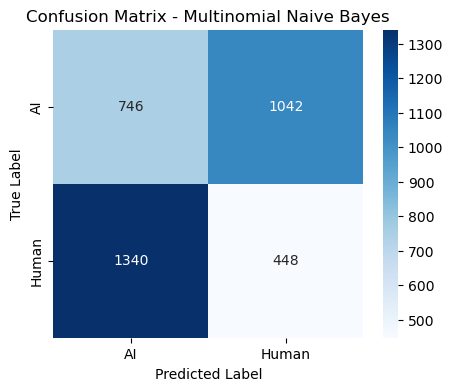

In [87]:
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 🚀 Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, train_data['label'])
log_y_pred = log_model.predict(X_test_tfidf)

# 🚀 Train Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, train_data['label'])
nb_y_pred = nb_model.predict(X_test_tfidf)

# Evaluate both models
log_accuracy = accuracy_score(test_data['label'], log_y_pred)
nb_accuracy = accuracy_score(test_data['label'], nb_y_pred)

# 📢 Print accuracy results
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")
print(f"Multinomial Naive Bayes Accuracy: {nb_accuracy:.4f}")

# 🚀 Updated Function to Fix Label Order
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["AI", "Human"],  # Swap labels to see if there was a problem with labels
                yticklabels=["AI", "Human"])  # Swap labels to see if there was a problem with labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


# 📊 Confusion Matrix for Logistic Regression
plot_confusion_matrix(test_data['label'], log_y_pred, "Confusion Matrix - Logistic Regression")

# 📊 Confusion Matrix for Naive Bayes
plot_confusion_matrix(test_data['label'], nb_y_pred, "Confusion Matrix - Multinomial Naive Bayes")
